In [2]:
# imports
import commands
from IPython.display import display
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns

In [135]:
# constants
window_width = float(17)/12
ball_diameter = 2.94/12
zone_width = window_width + ball_diameter

In [6]:
# specify database name
dbname = "../data/2016.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

In [7]:
# load pitchfx table to dataframe
pitches = pd.read_sql_query("select * from pitchfx",db)
pitches = pitches.dropna()

In [104]:
# load umpires table
umpires = pd.read_sql_query("select * from umpires",db)
umpires = umpires.dropna()

In [105]:
# load games table
games = pd.read_sql_query("select * from games",db)
games = games.dropna()

In [8]:
# extract called balls and strikes
balls = pitches[pitches.description=="Ball"]
strikes = pitches[pitches.description=="Called Strike"]

In [26]:
def plot_coords_desc(value):
    plt.scatter(pitches.px, pitches.pz, c='0.75', alpha=0.1, label="all")
    plt.scatter(pitches[pitches.description==value].px, pitches[pitches.description==value].pz, c='r', label=value)
    plt.xlabel("horizontal distance from middle of plate (ft)")
    plt.ylabel("height when crossing plate (ft)")
    plt.axis("equal")
    plt.grid()
    plt.legend(loc='lower right')
    plt.title(value)
    plt.show()

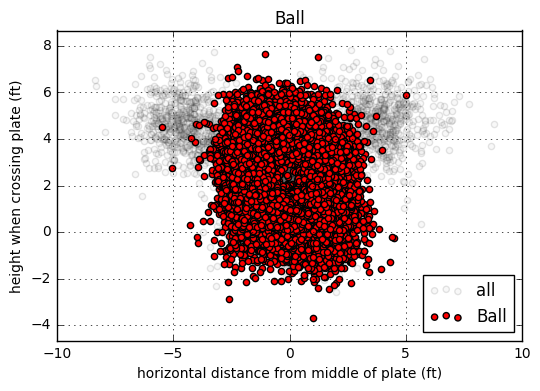

In [27]:
plot_coords_desc("Ball")

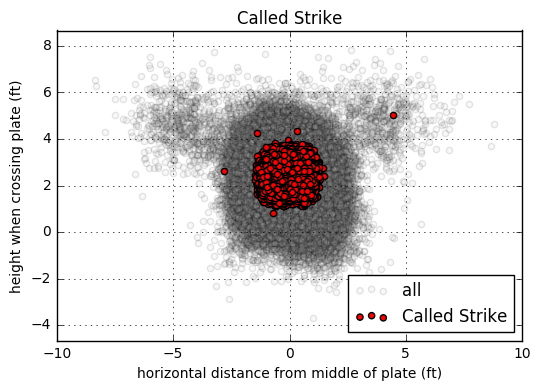

In [28]:
plot_coords_desc("Called Strike")

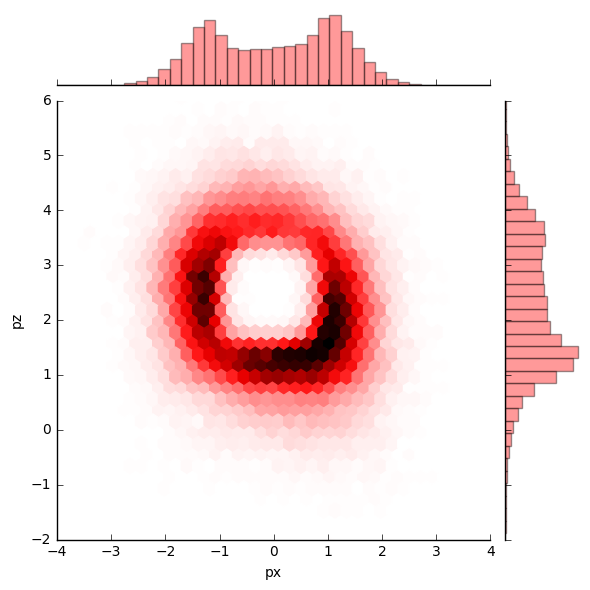

In [126]:
sns.jointplot(x="px", y="pz", data=balls, stat_func=None, kind="hex",xlim=[-4,4],ylim=[-2,6],color='r')
plt.show()

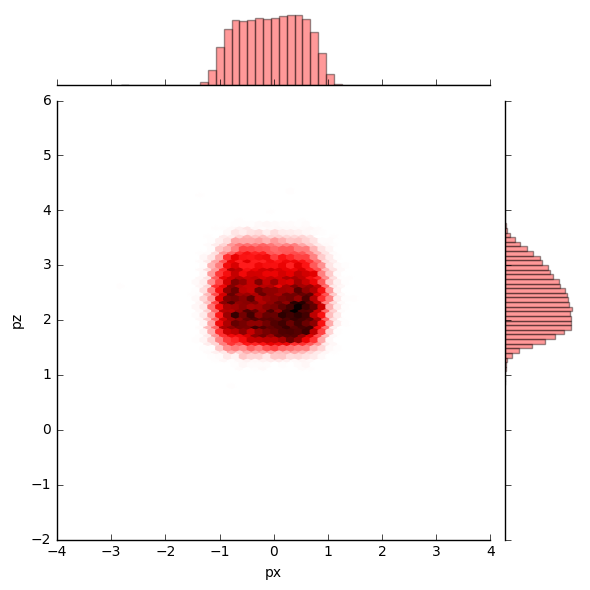

In [127]:
sns.jointplot(x="px", y="pz", data=strikes, stat_func=None, kind="hex",xlim=[-4,4],ylim=[-2,6],color='r')
plt.show()

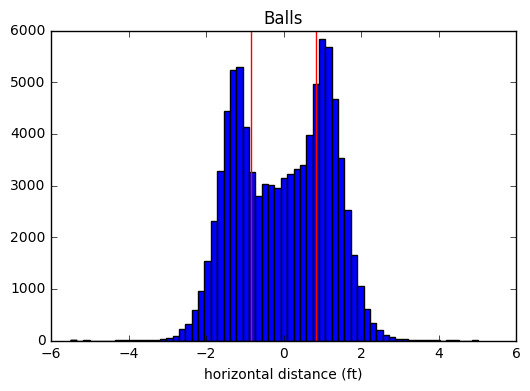

In [136]:
plt.hist(balls.px,bins=64)
plt.axvline(x=zone_width/2,c='r')
plt.axvline(x=-zone_width/2,c='r')
plt.xlabel("horizontal distance (ft)")
plt.title("Balls")
plt.show()

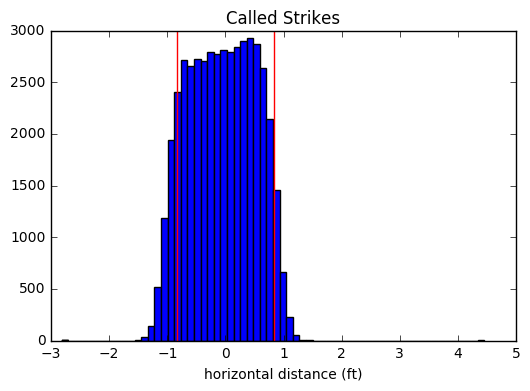

In [137]:
plt.hist(strikes.px,bins=64)
plt.axvline(x=zone_width/2,c='r')
plt.axvline(x=-zone_width/2,c='r')
plt.xlabel("horizontal distance (ft)")
plt.title("Called Strikes")
plt.show()

In [138]:
# extract balls around vertical center line (around 2.5 ft from the ground)
balls_center = balls[(balls.pz > 2.25) & (balls.pz < 2.75)]

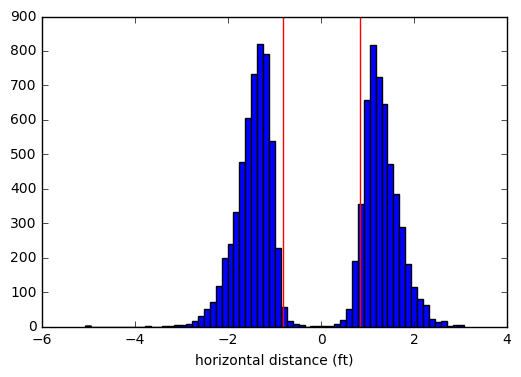

In [139]:
plt.hist(balls_center.px,bins=64)
plt.axvline(x=zone_width/2,c='r')
plt.axvline(x=-zone_width/2,c='r')
plt.xlabel("horizontal distance (ft)")
plt.show()

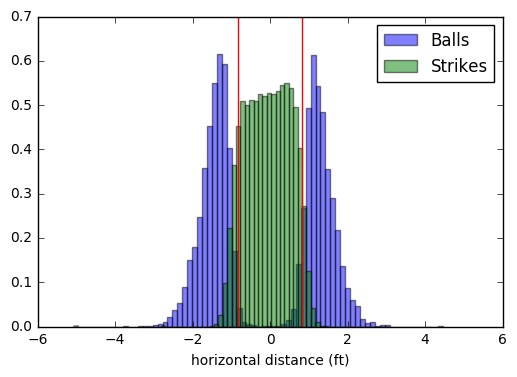

In [154]:
plt.hist(balls_center.px,bins=64,alpha=0.5,normed=True,label="Balls")
plt.hist(strikes.px,bins=64,alpha=0.5,normed=True,label="Strikes")
plt.legend()
plt.axvline(x=zone_width/2,c='r')
plt.axvline(x=-zone_width/2,c='r')
plt.xlabel("horizontal distance (ft)")
plt.show()

In [140]:
# false balls: pitches that were strikes but were called balls
false_balls = balls_center[(balls_center.px < zone_width/2) & (balls_center.px > -zone_width/2)]

# false strikes: pitches that were balls but were called strikes
false_strikes = strikes[(strikes.px < -zone_width/2) | (strikes.px > zone_width/2)]

In [142]:
# percent of false balls
num_false_balls = false_balls.shape[0]
num_all_balls = balls.shape[0]
print float(num_false_balls)/num_all_balls*100

0.469478465936


In [143]:
# percent of false strikes
num_false_strikes = false_strikes.shape[0]
num_all_strikes = strikes.shape[0]
print float(num_false_strikes)/num_all_strikes*100

14.9654643131


# Investigate umpire biases

In [106]:
umpires.columns

Index([u'umpire_id', u'umpire_name'], dtype='object')

In [107]:
pitches.columns

Index([u'game_id', u'pitch_num', u'at_bat', u'time', u'prev_event',
       u'description', u'outcome', u'pre_balls', u'post_balls', u'pre_strike',
       u'post_strike', u'start_speed', u'end_speed', u'sz_top', u'sz_bot',
       u'pfx_x', u'pfx_z', u'px', u'pz', u'x', u'y', u'x0', u'y0', u'z0',
       u'vx0', u'vy0', u'vz0', u'ax', u'ay', u'az', u'break_y', u'break_angle',
       u'break_length', u'spin_dir', u'spin_rate', u'pitch_type'],
      dtype='object')

In [108]:
games.columns

Index([u'game_id', u'game_type', u'date', u'game_time', u'home_id',
       u'visit_id', u'home_wins', u'home_losses', u'visit_wins',
       u'visit_losses', u'stadium_id', u'umpire_home', u'umpire_first',
       u'umpire_second', u'umpire_third'],
      dtype='object')

In [112]:
joined = pitches.merge(games,on="game_id").merge(umpires,left_on="umpire_home",right_on="umpire_id")

In [113]:
joined.columns

Index([u'game_id', u'pitch_num', u'at_bat', u'time', u'prev_event',
       u'description', u'outcome', u'pre_balls', u'post_balls', u'pre_strike',
       u'post_strike', u'start_speed', u'end_speed', u'sz_top', u'sz_bot',
       u'pfx_x', u'pfx_z', u'px', u'pz', u'x', u'y', u'x0', u'y0', u'z0',
       u'vx0', u'vy0', u'vz0', u'ax', u'ay', u'az', u'break_y', u'break_angle',
       u'break_length', u'spin_dir', u'spin_rate', u'pitch_type', u'game_type',
       u'date', u'game_time', u'home_id', u'visit_id', u'home_wins',
       u'home_losses', u'visit_wins', u'visit_losses', u'stadium_id',
       u'umpire_home', u'umpire_first', u'umpire_second', u'umpire_third',
       u'umpire_id', u'umpire_name'],
      dtype='object')

In [177]:
top_umpires = joined.umpire_name.value_counts().index

In [182]:
test_umpire_name = top_umpires[5]
one_umpire = joined[joined.umpire_name==test_umpire_name]
one_umpire_balls = one_umpire[one_umpire.description=="Ball"]
one_umpire_balls_center = one_umpire_balls[(one_umpire_balls.pz > 2.25) & (one_umpire_balls.pz < 2.75)]
one_umpire_strikes = one_umpire[one_umpire.description=="Called Strike"]

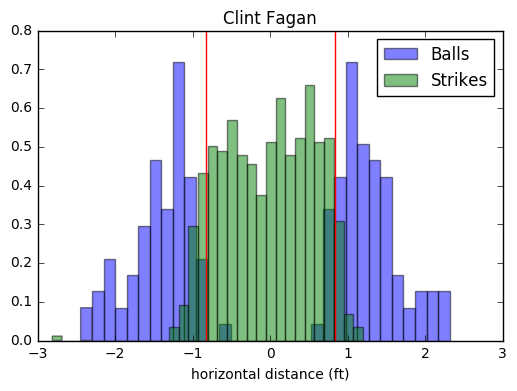

In [183]:
plt.hist(one_umpire_balls_center.px,bins=32,alpha=0.5,normed=True,label="Balls")
plt.hist(one_umpire_strikes.px,bins=32,alpha=0.5,normed=True,label="Strikes")
plt.legend()
plt.axvline(x=zone_width/2,c='r')
plt.axvline(x=-zone_width/2,c='r')
plt.xlabel("horizontal distance (ft)")
plt.title(test_umpire_name)
plt.show()


TODO:
1. How consistently do they call pitches right outside the strike zone?
2. If they consistently miscall strikes, how large is an umpire's effective strike zone?

